In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from data.attribute import YEAR_ATTR, IS_CITIZEN_ATTR, AGE_ATTR, SEX_ATTR, COMMUNE_SIZE_ATTR, SEX_MALE, SEX_FEMALE, \
    POPULATION_ATTR
from data.selects import apply_age_smoothing, apply_demographic_correction

In [2]:
from data.selects import get_fors_selects
from data.population import get_bfs_population_cga

selects_df = get_fors_selects()
population_df = get_bfs_population_cga()

In [3]:
year = selects_df[YEAR_ATTR].max()
electorate_year_df = population_df[
    (population_df[YEAR_ATTR] == year) &
    (population_df[IS_CITIZEN_ATTR]) &
    (population_df[AGE_ATTR] >= 18)
    ]
selects_year_df = apply_demographic_correction(
    apply_age_smoothing(selects_df[selects_df[YEAR_ATTR] == year]),
    electorate_year_df,
)

assert year == 2019

In [4]:
def calculate_participation(selects: pd.DataFrame) -> float:
    weights_sum = selects['weightc'].sum()
    return np.nan if weights_sum == 0 else ((selects['vp1'] == 'yes') * selects['weightc']).sum() / weights_sum


def calculate_interest(selects: pd.DataFrame) -> float:
    weights_sum = selects['weightc'].sum()
    interest = selects['pi1'].copy().cat.add_categories(['na']).fillna('na')
    return 0 if weights_sum == 0 else selects['weightc'].groupby(interest, observed=False).sum() / weights_sum


def describe_participation_extremes(series: pd.Series) -> None:
    """Print the lowest and highest participation values in a series."""
    attr_name = ' / '.join(map(str, series.index.names)) \
        if isinstance(series.index, pd.MultiIndex) else \
        series.index.name
    print(f"Participation Extremes by {attr_name}:")

    minimum, maximum = series.min(), series.max()
    min_idx = series.idxmin()
    max_idx = series.idxmax()
    min_label = ' / '.join(str(x) for x in min_idx) if isinstance(min_idx, tuple) else min_idx
    max_label = ' / '.join(str(x) for x in max_idx) if isinstance(max_idx, tuple) else max_idx
    print(f'  Lowest ({min_label}): {minimum * 100:0.2f}% ({minimum / maximum:0.2f}x of highest)')
    print(f'  Highest ({max_label}): {maximum * 100:0.2f}% ({maximum / minimum:0.2f}x of lowest)')

In [5]:
REAL_2019_TURNOUT = 0.451
selects_turnout = calculate_participation(selects_year_df)
print(f'Selects turnout: {selects_turnout:.3f}')
print(f'BFS turnout: {REAL_2019_TURNOUT:.3f}')

corrected_selects_year_df = selects_year_df.copy()
voted_mask = corrected_selects_year_df['vp1'] == 'yes'
corrected_selects_year_df.loc[voted_mask, 'weightc'] *= REAL_2019_TURNOUT / selects_turnout
corrected_selects_year_df.loc[~voted_mask, 'weightc'] *= (1 - REAL_2019_TURNOUT) / (1 - selects_turnout)
print(f'Corrected selects turnout: {calculate_participation(corrected_selects_year_df):.3f}')

Selects turnout: 0.710
BFS turnout: 0.451
Corrected selects turnout: 0.451


Participation Extremes by pi1:
  Lowest (not interested at all): 5.83% (0.07x of highest)
  Highest (very interested): 82.43% (14.15x of lowest)


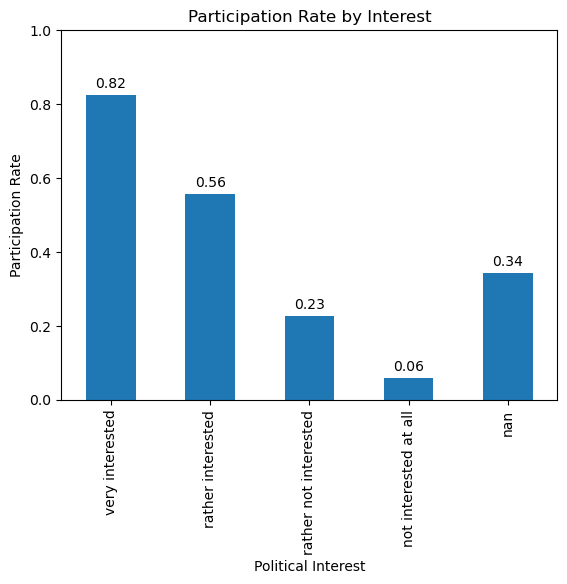

In [6]:
interest_participation = corrected_selects_year_df.groupby('pi1', dropna=False, observed=False).apply(
    calculate_participation, include_groups=False)
interest_participation.plot(
    kind='bar', ylim=(0, 1),
    title='Participation Rate by Interest',
    ylabel='Participation Rate',
    xlabel='Political Interest'
)
for i, v in enumerate(interest_participation):
    plt.text(i, v + 0.02, f'{v:.2f}', ha='center')

describe_participation_extremes(interest_participation)

Participation Extremes by Sex:
  Lowest (Female): 42.63% (0.89x of highest)
  Highest (Male): 47.93% (1.12x of lowest)


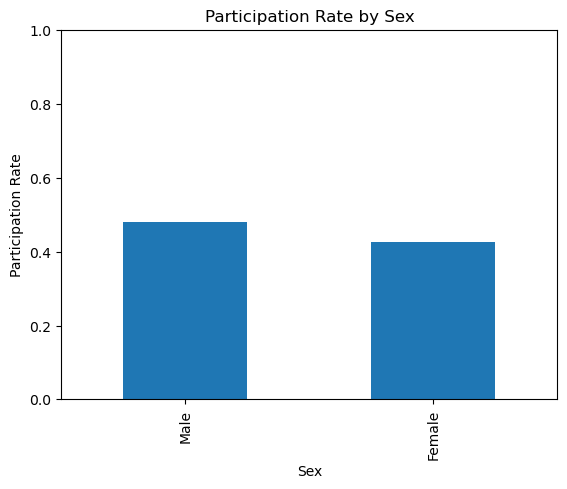

In [7]:
sex_participation = corrected_selects_year_df.groupby(SEX_ATTR, observed=False) \
    .apply(calculate_participation, include_groups=False)
sex_participation.plot(kind='bar', ylim=(0, 1), title='Participation Rate by Sex', ylabel='Participation Rate')
describe_participation_extremes(sex_participation)

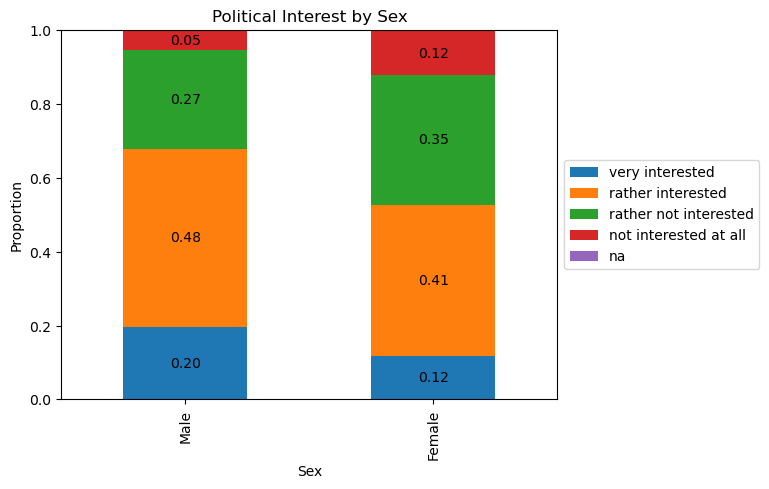

In [8]:
sex_interest = corrected_selects_year_df.groupby(SEX_ATTR, observed=True).apply(calculate_interest,
                                                                                include_groups=False)
ax = sex_interest.plot(
    kind='bar', ylim=(0, 1), title='Political Interest by Sex', ylabel='Proportion', stacked=True
)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# Add values to the bars
for category in sex_interest.index:
    bottoms = 0
    for interest_level, value in sex_interest.loc[category].items():
        if value > 0.05:
            plt.text(sex_interest.index.get_loc(category), bottoms + value / 2, f'{value:.2f}', ha='center',
                     va='center')
        bottoms += value

In [9]:
# Group very old people into a single group because of their small sample size
age_grouping = corrected_selects_year_df[AGE_ATTR].clip(upper=90)

Participation Extremes by Age:
  Lowest (28): 33.07% (0.54x of highest)
  Highest (70): 61.30% (1.85x of lowest)
Participation Extremes by Age / Sex:
  Lowest (30 / Female): 30.14% (0.41x of highest)
  Highest (70 / Male): 73.37% (2.43x of lowest)


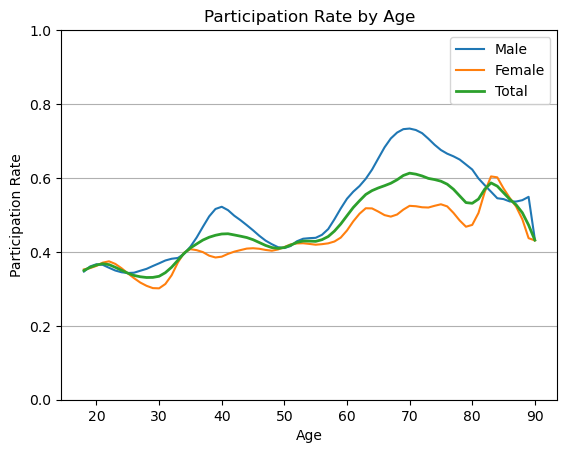

In [10]:
age_sex_participation = corrected_selects_year_df.groupby([age_grouping, SEX_ATTR], dropna=False, observed=True) \
    .apply(calculate_participation, include_groups=False)
age_participation = corrected_selects_year_df.groupby(age_grouping).apply(calculate_participation)

ax = age_sex_participation.unstack(level=SEX_ATTR).plot(
    ylim=(0, 1),
    title='Participation Rate by Age',
    ylabel='Participation Rate',
    grid=True,
)
age_participation.rename('Total').plot(ax=ax, linewidth=2)
ax.grid(axis='y')
ax.legend()

describe_participation_extremes(age_participation)
describe_participation_extremes(age_sex_participation)

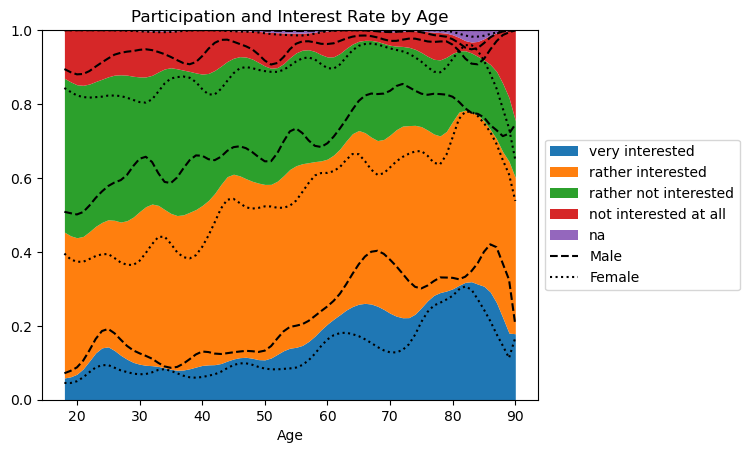

In [11]:
_SEX_LINE_STYLE = {
    SEX_MALE: '--',
    SEX_FEMALE: ':'
}

age_interest = corrected_selects_year_df.groupby(age_grouping).apply(calculate_interest)
age_sex_interest = corrected_selects_year_df.groupby([age_grouping, SEX_ATTR], dropna=False, observed=True) \
    .apply(calculate_interest, include_groups=False).unstack(level=SEX_ATTR)
available_sex = corrected_selects_year_df[SEX_ATTR].unique()

ax = age_interest.plot(
    kind='area', stacked=True, linewidth=0,
    title='Participation and Interest Rate by Age',
    ylim=(0, 1)
)
for sex in available_sex:
    age_sex_interest.xs(sex, level=SEX_ATTR, axis=1) \
        .plot(color='black', linestyle=_SEX_LINE_STYLE[sex], stacked=True, ax=ax)

# Modify the legend to show the correct labels
handles, labels = ax.get_legend_handles_labels()
area_handles = handles[:len(age_interest.columns)]  # Area plot handles
sex_handles = [
    handles[len(area_handles) + i * len(age_interest.columns)]
    for i in range(len(age_sex_interest.columns.get_level_values(SEX_ATTR).unique()))
]
ax.legend(
    area_handles + sex_handles,
    labels[:len(age_interest.columns)] + list(available_sex),
    loc='center left', bbox_to_anchor=(1, 0.5)
)

Participation Extremes by Commune Size:
  Lowest (1'000-1'999): 42.63% (0.79x of highest)
  Highest (50'000-99'999): 53.96% (1.27x of lowest)
Participation Extremes by Sex / Commune Size:
  Lowest (Female / 20'000-49'999): 39.30% (0.70x of highest)
  Highest (Female / 50'000-99'999): 56.18% (1.43x of lowest)


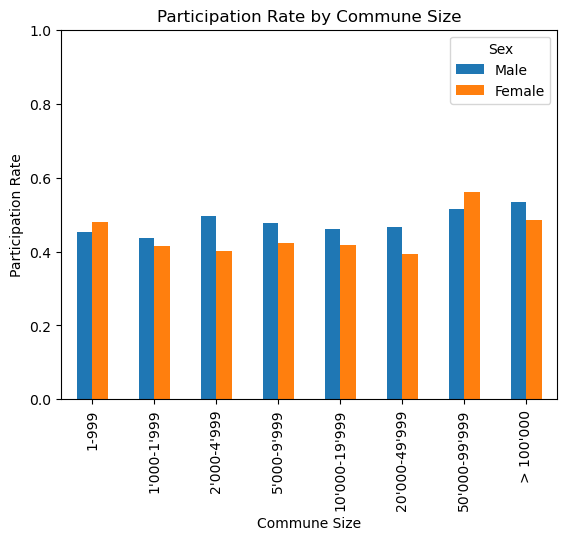

In [12]:
commune_size_participation = corrected_selects_year_df.groupby(COMMUNE_SIZE_ATTR, observed=True) \
    .apply(calculate_participation, include_groups=False)
commune_size_sex_participation = corrected_selects_year_df.groupby([SEX_ATTR, COMMUNE_SIZE_ATTR], observed=True) \
    .apply(calculate_participation, include_groups=False)

commune_size_sex_participation.unstack(level=SEX_ATTR).plot(
    kind='bar', ylim=(0, 1),
    title='Participation Rate by Commune Size',
    ylabel='Participation Rate'
)

describe_participation_extremes(commune_size_participation)
describe_participation_extremes(commune_size_sex_participation)

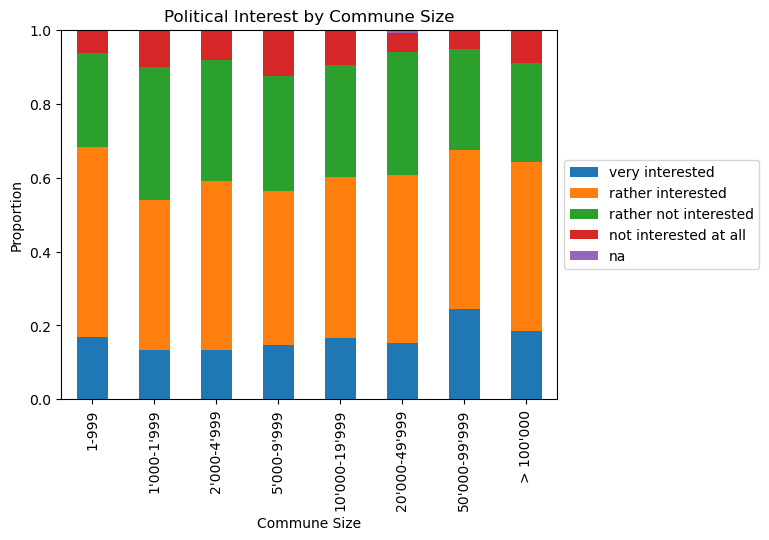

In [13]:
commune_size_interest = corrected_selects_year_df.groupby(COMMUNE_SIZE_ATTR, observed=True) \
    .apply(calculate_interest, include_groups=False)
ax = commune_size_interest.plot(
    kind='bar', ylim=(0, 1), stacked=True,
    title='Political Interest by Commune Size',
    ylabel='Proportion'
)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [14]:
electorate_demographics = electorate_year_df.groupby(
    [AGE_ATTR, SEX_ATTR, COMMUNE_SIZE_ATTR], observed=True, dropna=False
)[POPULATION_ATTR].sum()
electorate_demographics /= electorate_demographics.sum()

Participation Extremes by Age / Sex / Commune Size:
  Lowest (88 / Male / 1'000-1'999): 5.22% (0.05x of highest)
  Highest (89 / Female / 1-999): 100.00% (19.15x of lowest)


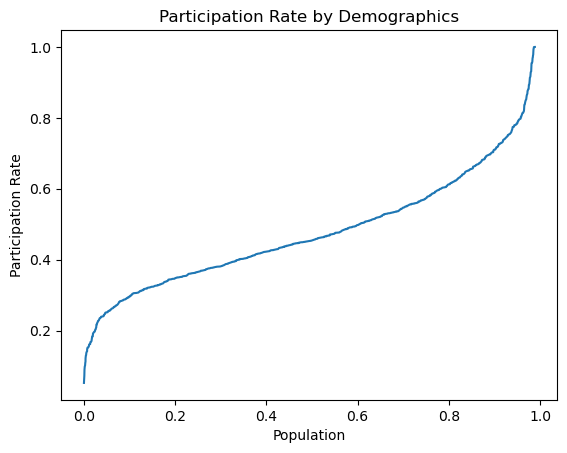

In [15]:
demographic_participation = corrected_selects_year_df \
    .groupby([age_grouping, SEX_ATTR, COMMUNE_SIZE_ATTR], observed=True) \
    .apply(calculate_participation, include_groups=False) \
    .sort_values()

demographic_participation.set_axis(electorate_demographics[demographic_participation.index].cumsum()).plot(
    title='Participation Rate by Demographics',
    ylabel='Participation Rate'
)

describe_participation_extremes(demographic_participation)

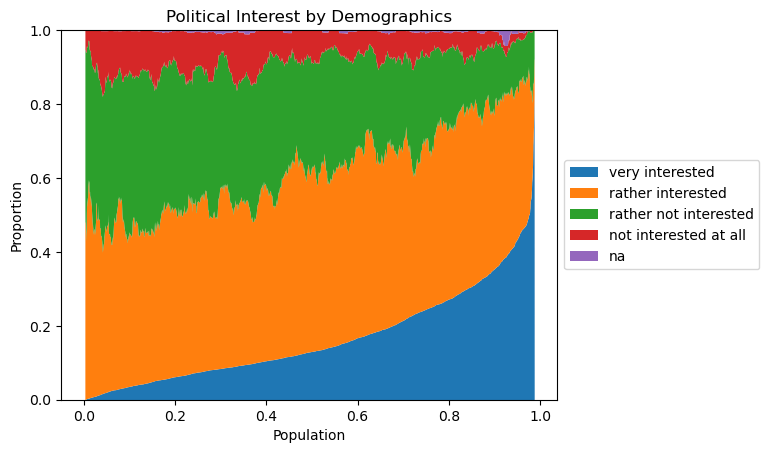

In [16]:
demographic_interest = corrected_selects_year_df \
    .groupby([age_grouping, SEX_ATTR, COMMUNE_SIZE_ATTR], observed=True) \
    .apply(calculate_interest, include_groups=False) \
    .sort_values('very interested')

ax = demographic_interest.set_index(electorate_demographics[demographic_interest.index].cumsum()) \
    .rolling(20, center=True).mean() \
    .plot(
    kind='area', stacked=True, ylim=(0, 1), linewidth=0,
    title='Political Interest by Demographics',
    ylabel='Proportion'
)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))